# Using MIS to Color Graphs
In this notebook, we will present our implementation of graph coloring by repeatedly finding maximum independent set, which neutral-atom quantum computers are very well-suited for. While Bloqade is offered in both Python and Julia, we chose to use the Julia version 

In [1]:
using Graphs
using Bloqade
using Random
using PyCall
using GenericTensorNetworks

In [2]:
function MIS_QAA(atoms, graph)
    T_max = 0.6
    Ω_max = 2π * 4
    Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
    Δ_start = -2π * 13
    Δ_end = 2π * 11
    Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])
    hamiltonian = rydberg_h(atoms; Ω = Ω, Δ = Δ)
    prob = SchrodingerProblem(zero_state(nqubits(hamiltonian)), T_max, hamiltonian)
    emulate!(prob)
    best_bit_strings = most_probable(prob.reg, 3)
    return [mis_postprocessing(val, graph) for val in best_bit_strings]
end

MIS_QAA (generic function with 1 method)

In [3]:
function coloring(atoms, find_colors, color, result, minres, quantum=true)
    if size(find_colors,1) == 0
        return result
    end
    graph = BloqadeMIS.unit_disk_graph(find_colors, 7.5)
    res = quantum ? MIS_QAA(atoms, graph) : read_config(GenericTensorNetworks.solve(GenericTensorNetwork(IndependentSet(graph)), ConfigsMax(; bounded=true))[])
    for bitstring in res
        to_delete = []
        for (i, b) in enumerate(bitstring)
            if b == 1
                idx = findfirst(elem -> elem == find_colors[i], atoms)
                push!(to_delete, atoms[idx])
                result[atoms[idx]] = color
            end
        end
        optres = coloring(atoms, [elem for (i, elem) in enumerate(find_colors) if !(elem in to_delete)], color+1, result, minres, quantum)
        if isempty(minres) || findmax(optres)[1] < findmax(minres)[1]
            minres = copy(optres)
        end
    end
    return minres
end

coloring (generic function with 2 methods)

Dict{Any, Any}((29.892710443754744, 32.80445652252062) => 1, (33.0162744566722, 0.23088873720594805) => 2, (0.0, 54.3266694737127) => 1, (38.95646674717212, 0.0) => 1, (38.36108917613059, 32.22098257592155) => 3, (38.16964465929892, 36.78536309289648) => 1, (35.51210108659508, 34.86184715652474) => 2)


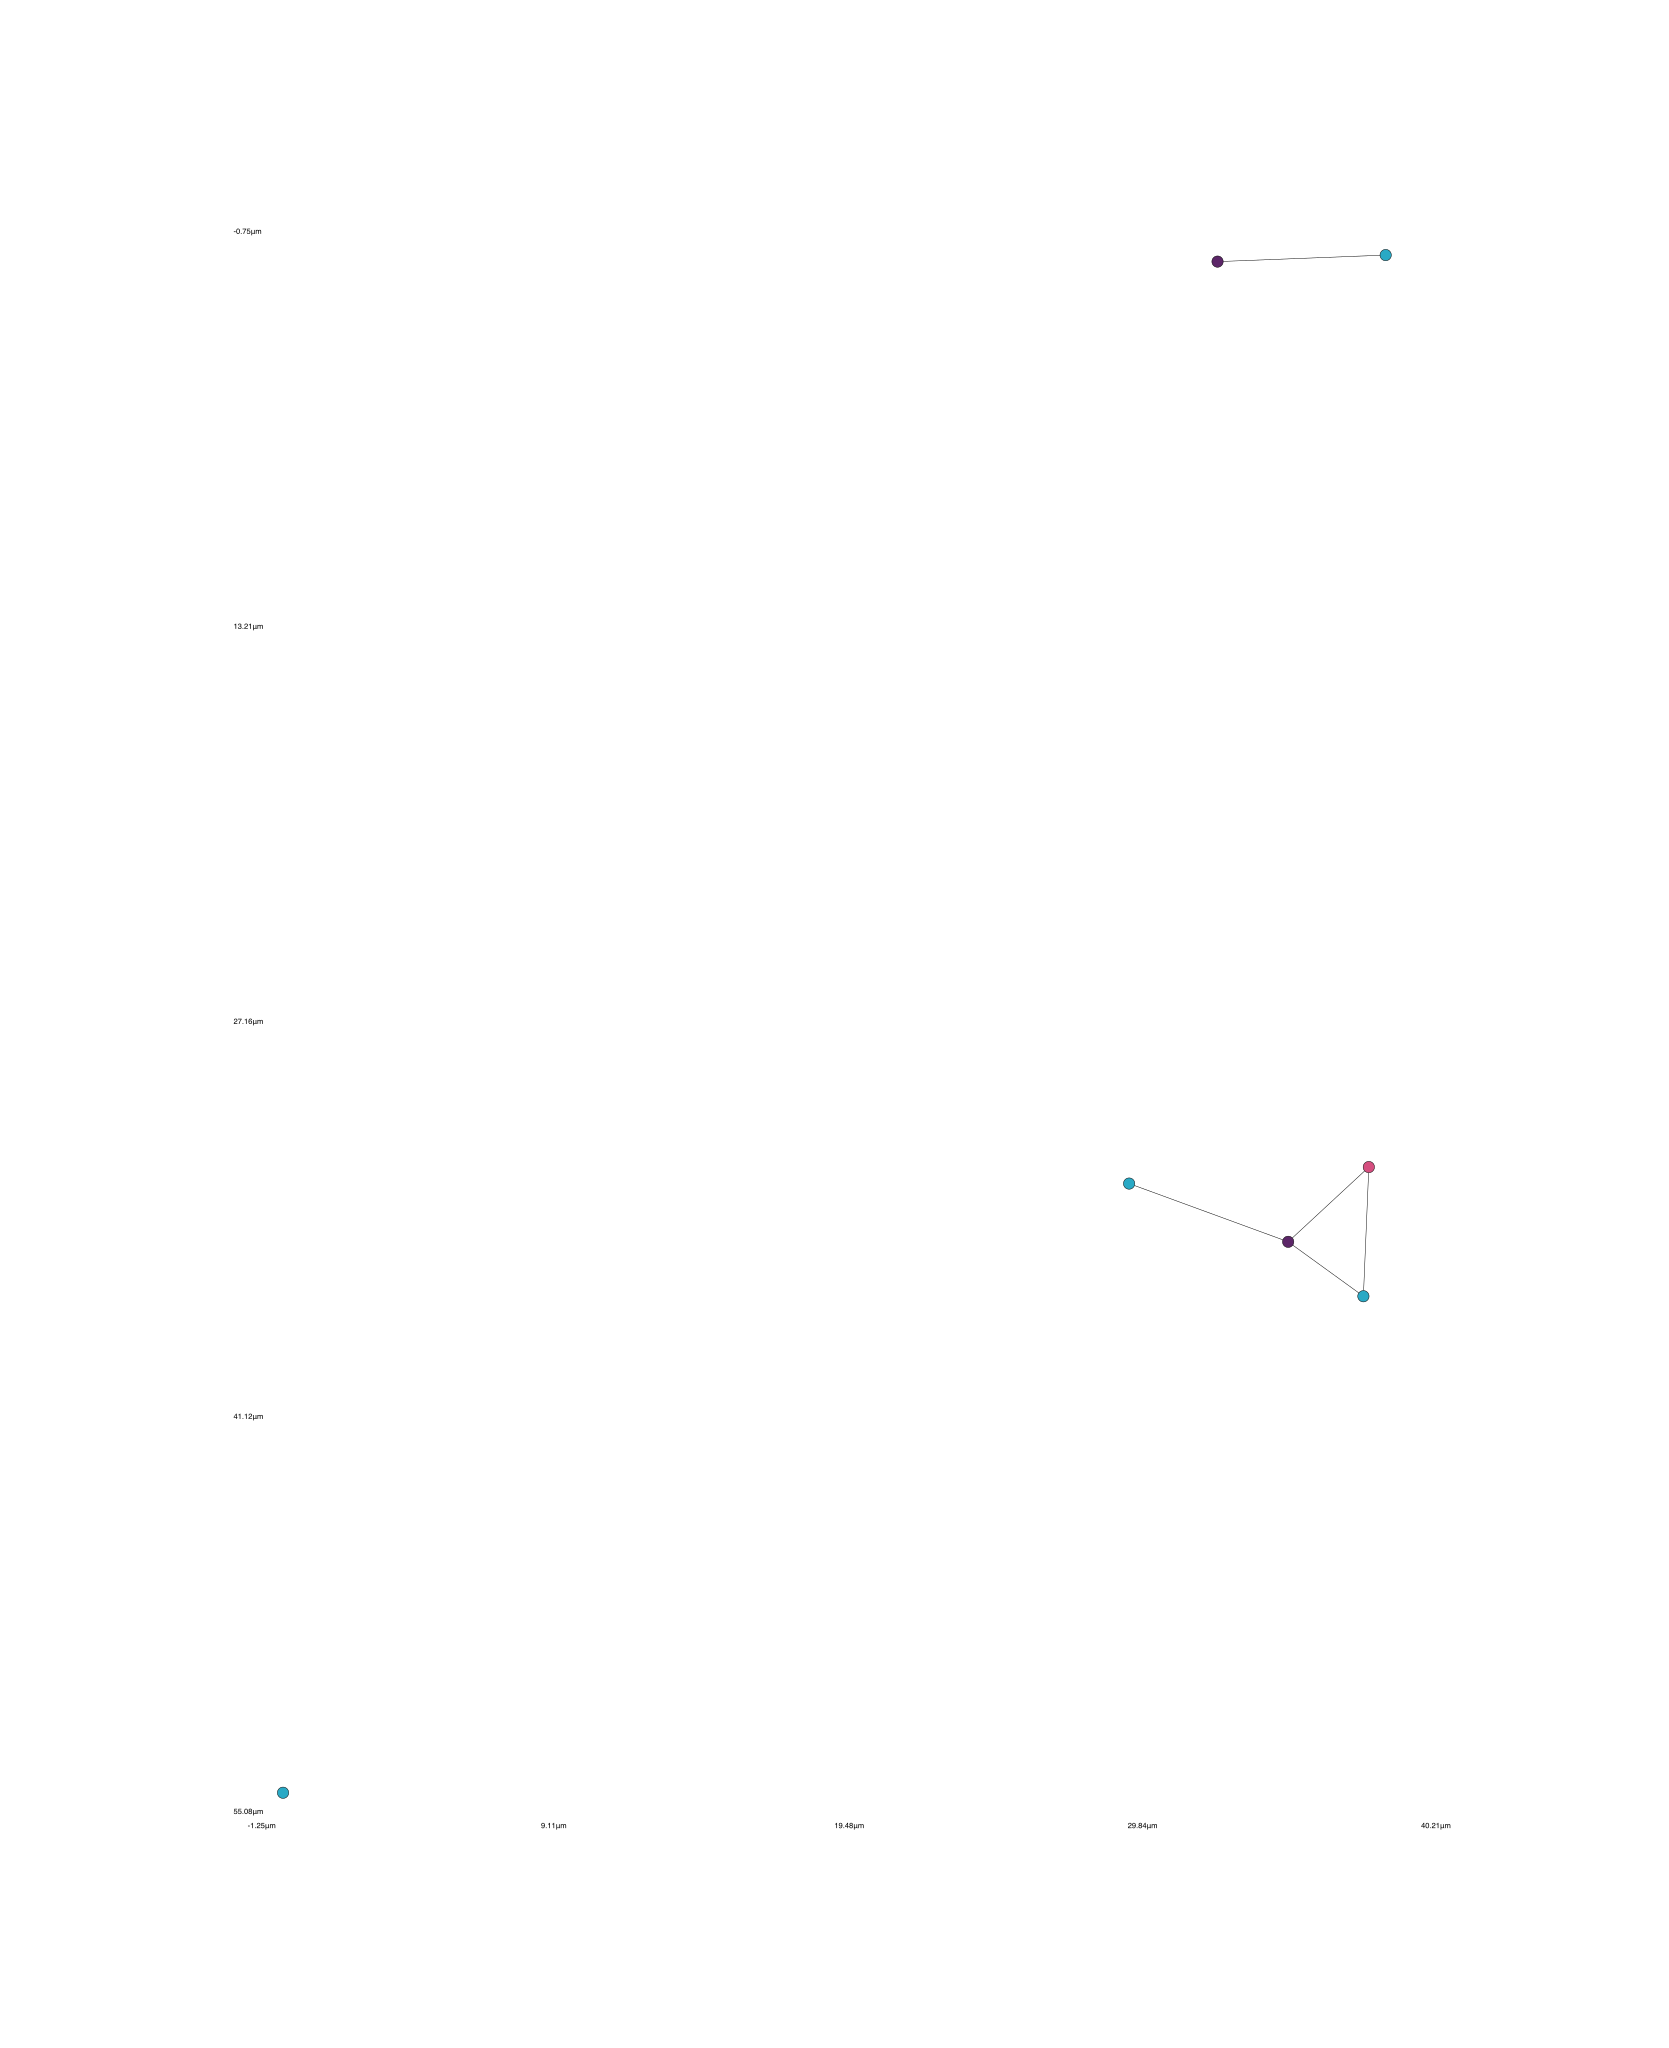

In [6]:
pickle = pyimport("pickle")
open("graph.pickle") do f
    positions = pickle.load(f)
    atoms = AtomList(positions)
    output = coloring(atoms, copy(atoms), 1, Dict(), Dict(), true)
    colors = Dict(i => string("#",randstring(['0':'9'; 'a':'f'], 6)) for i in 1:findmax(output)[1])
    print(output, "\n")
    Bloqade.plot(atoms, blockade_radius = 7.5; colors = [colors[output[elem]] for elem in atoms])
end